Stolen from: https://github.com/shayneobrien/generative-models

# Utilities

In [29]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms

lastnumberforvalidation=10000
lastnumberforvalidation=20

defaultBATCH_SIZE=100
defaultBATCH_SIZE=10

dataroot = "../data/"

image_size= 64

def to_var(x):
    """ Make a tensor cuda-erized and requires gradient """
    return to_cuda(x).requires_grad_()

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

def get_data(BATCH_SIZE=defaultBATCH_SIZE):
    """ Load data for binared MNIST """
    torch.manual_seed(3435)

    # Download our data
#     train_dataset = datasets.MNIST(root='./data/',
#                                     train=True,
#                                     transform=transforms.ToTensor(),
#                                     download=True)


#     test_dataset = datasets.MNIST(root='./data/',
#                                    train=False,
#                                    transform=transforms.ToTensor())


    dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               #transforms.functional.adjust_contrast(contrast_factor=5),
                               #transforms.Normalize(mean=[0.5], std=[0.5]),
                               transforms.ColorJitter(brightness=(10,10),contrast=(5,5)),
                               transforms.ToTensor(),
                               #transforms.functional.adjust_contrast(contrast_factor=5),
                               #transforms.Normalize(mean=[0.5], std=[0.5]),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    test_dataset=dataset
    train_dataset=dataset
    
    for d in train_dataset:
        print(d[0])
        break

    # Use greyscale values as sampling probabilities to get back to [0,1]
    train_img = torch.stack([torch.bernoulli(d[0]) for d in train_dataset])
    train_label = torch.LongTensor([d[1] for d in train_dataset])

    test_img = torch.stack([torch.bernoulli(d[0]) for d in test_dataset])
    test_label = torch.LongTensor([d[1] for d in test_dataset])

    # MNIST has no official train dataset so use last 10000 as validation
    val_img = train_img[-lastnumberforvalidation:].clone()
    val_label = train_label[-lastnumberforvalidation:].clone()

    train_img = train_img[:-lastnumberforvalidation]
    train_label = train_label[:-lastnumberforvalidation]

    # Create data loaders
    train = torch.utils.data.TensorDataset(train_img, train_label)
    val = torch.utils.data.TensorDataset(val_img, val_label)
    test = torch.utils.data.TensorDataset(test_img, test_label)

    train_iter = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_iter = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE, shuffle=True)
    test_iter = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

    return train_iter, val_iter, test_iter



# VAE Definition

In [30]:
""" (VAE) https://arxiv.org/abs/1312.6114
Variational Autoencoder

From the abstract:

"We introduce a stochastic variational inference and learning algorithm that
scales to large datasets and, under some mild differentiability conditions,
even works in the intractable case. Our contributions is two-fold. First, we
show that a reparameterization of the variational lower bound yields a lower
bound estimator that can be straightforwardly optimized using standard
stochastic gradient methods. Second, we show that for i.i.d. datasets with
continuous latent variables per datapoint, posterior inference can be made
especially efficient by fitting an approximate inference model (also called a
recognition model) to the intractable posterior using the proposed lower bound
estimator."

Basically VAEs encode an input into a given dimension z, reparametrize that z
using it's mean and std, and then reconstruct the image from reparametrized z.
This lets us tractably model latent representations that we may not be
explicitly aware of that are in the data. For a simple example of what this may
look like, read up on "Karl Pearson's Crabs." The basic idea was that a
scientist collected data on a population of crabs, noticed that the distribution
was non-normal, and Pearson postulated it was because there were likely more
than one population of crabs studied. This would've been a latent variable,
since the data colllector did not initially know or perhaps even suspect this.
"""

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
from itertools import product


class Encoder(nn.Module):
    """ MLP encoder for VAE. Input is an image,
    outputs are the mean, std of the latent variable z pre-reparametrization
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()

        self.linear = nn.Linear(image_size, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.log_var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        activated = F.relu(self.linear(x))
        mu, log_var = self.mu(activated), self.log_var(activated)
        return mu, log_var


class Decoder(nn.Module):
    """ MLP decoder for VAE. Input is a reparametrized latent representation,
    output is reconstructed image
    """
    def __init__(self, z_dim, hidden_dim, image_size):
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.recon = nn.Linear(hidden_dim, image_size)

    def forward(self, z):
        activated = F.relu(self.linear(z))
        reconstructed = torch.sigmoid(self.recon(activated))
        return reconstructed


class VAE(nn.Module):
    """ VAE super class to reconstruct an image. Contains reparametrization
    method for latent variable z
    """
    def __init__(self, image_size=784, hidden_dim=400, z_dim=20):
        super().__init__()

        self.__dict__.update(locals())

        self.encoder = Encoder(image_size=image_size, hidden_dim=hidden_dim, z_dim=z_dim)
        self.decoder = Decoder(z_dim=z_dim, hidden_dim=hidden_dim, image_size=image_size)

        self.shape = int(image_size ** 0.5)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        out_img = self.decoder(z)
        return out_img, mu, log_var

    def reparameterize(self, mu, log_var):
        """" Reparametrization trick: z = mean + std*epsilon,
        where epsilon ~ N(0, 1).
        """
        epsilon = to_cuda(torch.randn(mu.shape))
        z = mu + epsilon * torch.exp(log_var/2) # 2 for convert var to std
        return z


class VAETrainer:
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        """ Object to hold data iterators, train the model """
        self.model = to_cuda(model)
        self.name = model.__class__.__name__

        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter

        self.best_val_loss = 1e10
        self.debugging_image, _ = next(iter(test_iter))
        self.viz = viz

        self.kl_loss = []
        self.recon_loss = []
        self.num_epochs = 0

    def train(self, num_epochs, lr=1e-3, weight_decay=1e-5):
        """ Train a Variational Autoencoder

            Logs progress using total loss, reconstruction loss, kl_divergence,
            and validation loss

        Inputs:
            num_epochs: int, number of epochs to train for
            lr: float, learning rate for Adam optimizer
            weight_decay: float, weight decay for Adam optimizer
        """
        # Adam optimizer, sigmoid cross entropy for reconstructing binary MNIST
        optimizer = optim.Adam(params=[p for p in self.model.parameters()
                                      if p.requires_grad],
                               lr=lr,
                               weight_decay=weight_decay)

        # Begin training
        for epoch in tqdm(range(1, num_epochs+1)):

            self.model.train()
            epoch_loss, epoch_recon, epoch_kl = [], [], []

            for batch in self.train_iter:

                # Zero out gradients
                optimizer.zero_grad()

                # Compute reconstruction loss, Kullback-Leibler divergence
                # for a batch for the variational lower bound (ELBO)
                recon_loss, kl_diverge = self.compute_batch(batch)
                batch_loss = recon_loss + kl_diverge

                # Update parameters
                batch_loss.backward()
                optimizer.step()

                # Log metrics
                epoch_loss.append(batch_loss.item())
                epoch_recon.append(recon_loss.item())
                epoch_kl.append(kl_diverge.item())

            # Save progress
            self.kl_loss.extend(epoch_kl)
            self.recon_loss.extend(epoch_recon)

            # Test the model on the validation set
            self.model.eval()
            val_loss = self.evaluate(self.val_iter)

            # Early stopping
            if val_loss < self.best_val_loss:
                self.best_model = deepcopy(self.model)
                self.best_val_loss = val_loss

            # Progress logging
            print ("Epoch[%d/%d], Total Loss: %.4f, Reconst Loss: %.4f, KL Div: %.7f, Val Loss: %.4f"
                   %(epoch, num_epochs, np.mean(epoch_loss),
                   np.mean(epoch_recon), np.mean(epoch_kl), val_loss))
            self.num_epochs += 1

            # Debugging and visualization purposes
            if self.viz:
                self.sample_images(epoch)
                plt.show()

    def compute_batch(self, batch):
        """ Compute loss for a batch of examples """
        # Reshape images
        images, _ = batch
        images = to_cuda(images.view(images.shape[0], -1))

        # Get output images, mean, std of encoded space
        outputs, mu, log_var = self.model(images)

        # L2 (mean squared error) loss
        recon_loss = torch.sum((images - outputs) ** 2)

        # Kullback-Leibler divergence between encoded space, Gaussian
        kl_diverge = self.kl_divergence(mu, log_var)

        return recon_loss, kl_diverge

    def kl_divergence(self, mu, log_var):
        """ Compute Kullback-Leibler divergence """
        return torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var - 1))

    def evaluate(self, iterator):
        """ Evaluate on a given dataset """
        loss = []
        for batch in iterator:
            recon_loss, kl_diverge = self.compute_batch(batch)
            batch_loss = recon_loss + kl_diverge
            loss.append(batch_loss.item())

        loss = np.mean(loss)
        return loss

    def reconstruct_images(self, images, epoch, save=True):
        """ Sample images from latent space at each epoch """
        # Reshape images, pass through model, reshape reconstructed output
        batch = to_cuda(images.view(images.shape[0], -1))
        reconst_images, _, _ = self.model(batch)
        reconst_images = reconst_images.view(images.shape).squeeze()

        # Plot
        plt.close()
        grid_size, k = int(reconst_images.shape[0]**0.5), 0
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow(reconst_images[k].data.numpy(), cmap='gray')
            k += 1

        # Save
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.data,
                                         outname + 'real.png',
                                         nrow=grid_size)
            torchvision.utils.save_image(reconst_images.unsqueeze(1).data,
                                         outname + 'reconst_%d.png' %(epoch),
                                         nrow=grid_size)

    def sample_images(self, epoch=-100, num_images=36, save=True):
        """ Viz method 1: generate images by sampling z ~ p(z), x ~ p(x|z,θ) """
        # Sample z
        z = to_cuda(torch.randn(num_images, self.model.z_dim))

        # Pass into decoder
        sample = self.model.decoder(z)

        # Plot
        to_img = ToPILImage()
        img = to_img(make_grid(sample.data.view(num_images, 
                                                -1, 
                                                self.model.shape, 
                                                self.model.shape),
                     nrow=int(num_images**0.5)))
        display(img)

        # Save
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            img.save(outname + 'sample_%d.png' %(epoch))

    def sample_interpolated_images(self):
        """ Viz method 2: sample two random latent vectors from p(z),
        then sample from their interpolated values
        """
        # Sample latent vectors
        z1 = torch.normal(torch.zeros(self.model.z_dim), 1)
        z2 = torch.normal(torch.zeros(self.model.z_dim), 1)
        to_img = ToPILImage()

        # Interpolate within latent vectors
        for alpha in np.linspace(0, 1, self.model.z_dim):
            z = to_cuda(alpha*z1 + (1-alpha)*z2)
            sample = self.model.decoder(z)
            display(to_img(make_grid(sample.data.view(-1,
                                                      self.model.shape,
                                                      self.model.shape))))

    def explore_latent_space(self, num_epochs=3):
        """ Viz method 3: train a VAE with 2 latent variables,
        compare variational means
        """
        # Initialize and train a VAE with size two dimension latent space
        train_iter, val_iter, test_iter = get_data()
        latent_model = VAE(image_size=784, hidden_dim=400, z_dim=2)
        latent_space = VAETrainer(latent_model, train_iter, val_iter, test_iter)
        latent_space.train(num_epochs)
        latent_model = latent_space.best_model

        # Across batches in train iter, collect variationa means
        data = []
        for batch in train_iter:
            images, labels = batch
            images = to_cuda(images.view(images.shape[0], -1))
            mu, log_var = latent_model.encoder(images)

            for label, (m1, m2) in zip(labels, mu):
                data.append((label.item(), m1.item(), m2.item()))

        # Plot
        labels, m1s, m2s = zip(*data)
        plt.figure(figsize=(10,10))
        plt.scatter(m1s, m2s, c=labels)
        plt.legend([str(i) for i in set(labels)])

        # Evenly sample across latent space, visualize the outputs
        mu = torch.stack([torch.FloatTensor([m1, m2])
                          for m1 in np.linspace(-2, 2, 10)
                          for m2 in np.linspace(-2, 2, 10)])
        samples = latent_model.decoder(to_cuda(mu))
        to_img = ToPILImage()
        display(to_img(make_grid(samples.data.view(mu.shape[0],
                                                   -1,
                                                   latent_model.shape,
                                                   latent_model.shape),
                                 nrow=10)))

        return latent_model

    def make_all(self):
        """ Execute all latent space viz methods outlined in this class """

        print('Sampled images from latent space:')
        self.sample_images(save=False)

        print('Interpolating between two randomly sampled')
        self.sample_interpolated_images()

        print('Exploring latent representations')
        _ = self.explore_latent_space()

    def viz_loss(self):
        """ Visualize reconstruction loss """
        # Set style, figure size
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        # Plot reconstruction loss in red, KL divergence in green
        plt.plot(np.linspace(1, self.num_epochs, len(self.recon_loss)),
                 self.recon_loss,
                 'r')
        plt.plot(np.linspace(1, self.num_epochs, len(self.kl_loss)),
                 self.kl_loss,
                 'g')

        # Add legend, title
        plt.legend(['Reconstruction', 'Kullback-Leibler'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)

    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)

# if __name__ == "__main__":

#     # Load in binzarized MNIST data, separate into data loaders
#     train_iter, val_iter, test_iter = get_data()

#     # Init model
#     model = VAE(image_size=784,
#                 hidden_dim=400,
#                 z_dim=20)

#     # Init trainer
#     trainer = VAETrainer(model=model,
#                       train_iter=train_iter,
#                       val_iter=val_iter,
#                       test_iter=test_iter,
#                       viz=False)

#     # Train
#     trainer.train(num_epochs=5,
#                   lr=1e-3,
#                   weight_decay=1e-5)


# Run things

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch[1/25], Total Loss: 2357.7093, Reconst Loss: 2153.4210, KL Div: 204.2883056, Val Loss: 2285.2889


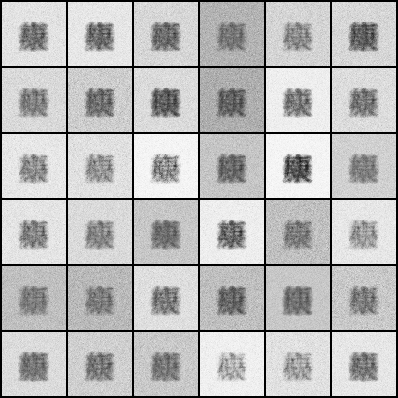

  4%|▍         | 1/25 [00:50<20:05, 50.23s/it]

Epoch[2/25], Total Loss: 1695.1765, Reconst Loss: 1603.3946, KL Div: 91.7819215, Val Loss: 1859.0776


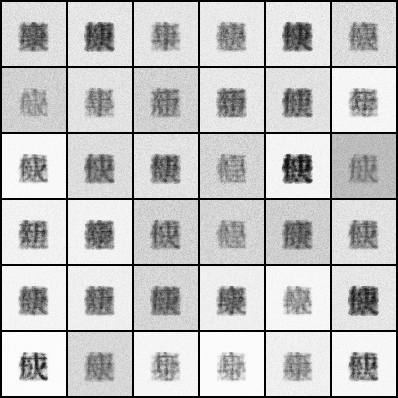

  8%|▊         | 2/25 [01:41<19:24, 50.61s/it]

Epoch[3/25], Total Loss: 1529.6772, Reconst Loss: 1420.0055, KL Div: 109.6716423, Val Loss: 1858.0175


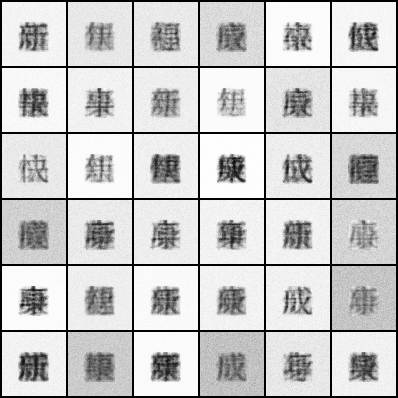

 12%|█▏        | 3/25 [02:27<17:48, 48.59s/it]

Epoch[4/25], Total Loss: 1391.6781, Reconst Loss: 1259.8074, KL Div: 131.8707398, Val Loss: 1812.9398


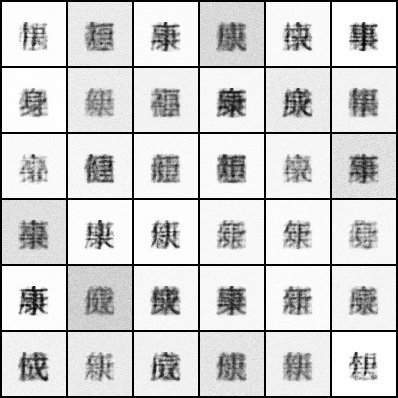

 16%|█▌        | 4/25 [03:17<17:17, 49.40s/it]

Epoch[5/25], Total Loss: 1305.5934, Reconst Loss: 1162.3156, KL Div: 143.2778884, Val Loss: 1693.5757


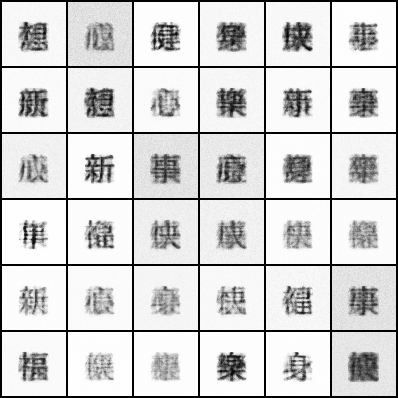

 20%|██        | 5/25 [04:08<16:32, 49.65s/it]

Epoch[6/25], Total Loss: 1245.1382, Reconst Loss: 1097.6398, KL Div: 147.4984337, Val Loss: 1644.7457


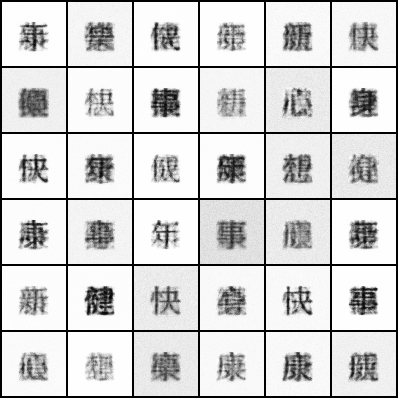

 24%|██▍       | 6/25 [04:59<15:55, 50.30s/it]

Epoch[7/25], Total Loss: 1190.6046, Reconst Loss: 1040.3273, KL Div: 150.2772923, Val Loss: 1507.4732


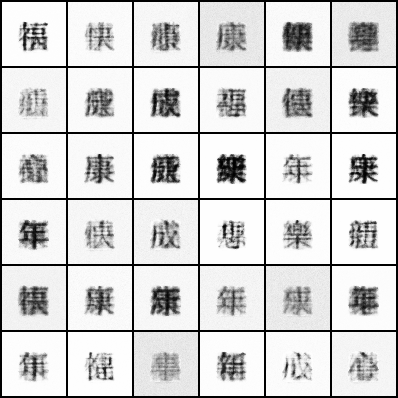

 28%|██▊       | 7/25 [05:52<15:21, 51.18s/it]

Epoch[8/25], Total Loss: 1162.7310, Reconst Loss: 1012.1833, KL Div: 150.5476955, Val Loss: 1459.3395


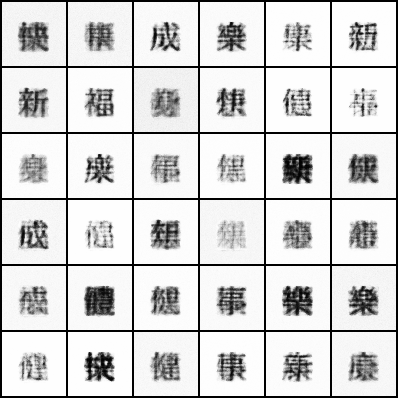

 32%|███▏      | 8/25 [06:49<14:59, 52.90s/it]

Epoch[9/25], Total Loss: 1138.2408, Reconst Loss: 987.8117, KL Div: 150.4291434, Val Loss: 1455.1895


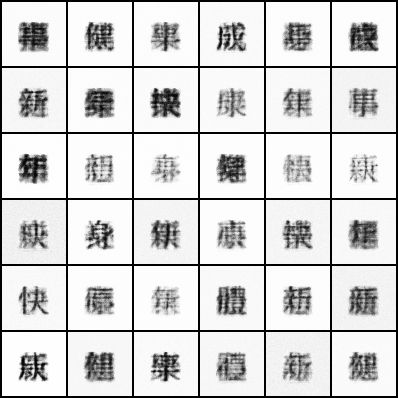

 36%|███▌      | 9/25 [07:35<13:32, 50.79s/it]

Epoch[10/25], Total Loss: 1142.7750, Reconst Loss: 990.5921, KL Div: 152.1829047, Val Loss: 1383.5998


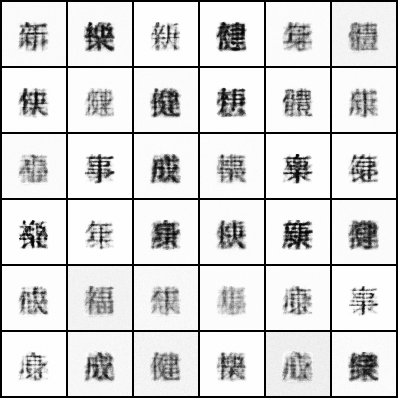

 40%|████      | 10/25 [08:22<12:25, 49.73s/it]

Epoch[11/25], Total Loss: 1117.3380, Reconst Loss: 967.9911, KL Div: 149.3469639, Val Loss: 1318.2785


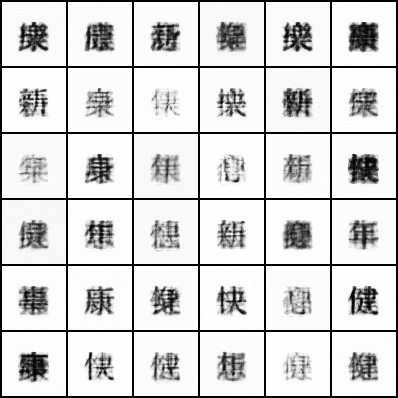

 44%|████▍     | 11/25 [09:07<11:17, 48.36s/it]

Epoch[12/25], Total Loss: 1100.8348, Reconst Loss: 947.6909, KL Div: 153.1439887, Val Loss: 1305.8613


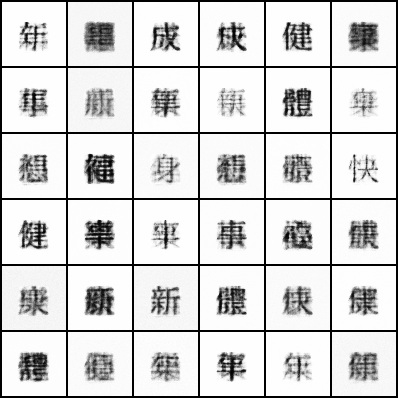

 48%|████▊     | 12/25 [09:55<10:23, 48.00s/it]

Epoch[13/25], Total Loss: 1072.6144, Reconst Loss: 919.1138, KL Div: 153.5006106, Val Loss: 1234.4422


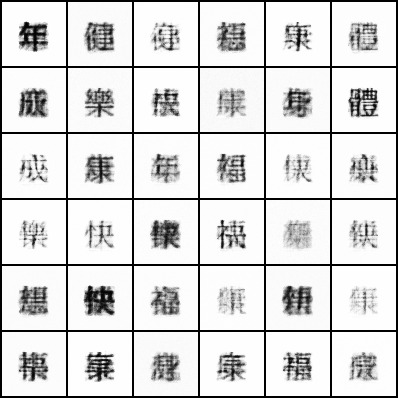

 52%|█████▏    | 13/25 [10:46<09:49, 49.14s/it]

Epoch[14/25], Total Loss: 1064.0082, Reconst Loss: 912.1483, KL Div: 151.8598563, Val Loss: 1236.8929


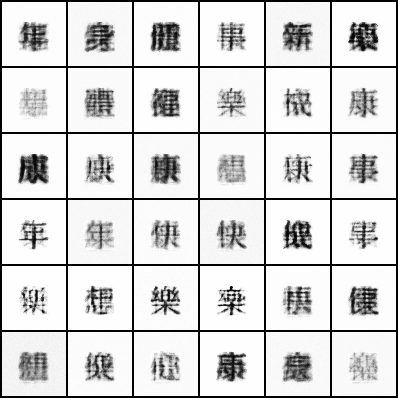

 56%|█████▌    | 14/25 [11:38<09:09, 49.98s/it]

Epoch[15/25], Total Loss: 1056.7873, Reconst Loss: 903.7805, KL Div: 153.0067923, Val Loss: 1268.6830


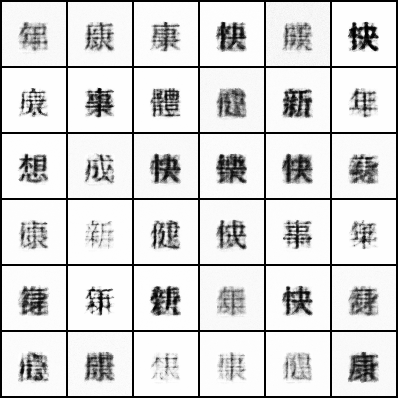

 60%|██████    | 15/25 [12:30<08:24, 50.49s/it]

Epoch[16/25], Total Loss: 1053.7696, Reconst Loss: 896.8821, KL Div: 156.8874971, Val Loss: 1232.6193


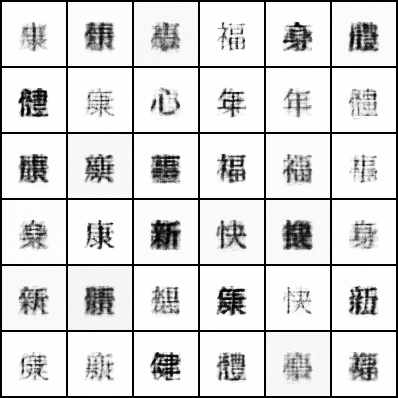

 64%|██████▍   | 16/25 [13:23<07:41, 51.24s/it]

Epoch[17/25], Total Loss: 1023.5888, Reconst Loss: 870.2019, KL Div: 153.3868434, Val Loss: 1212.9467


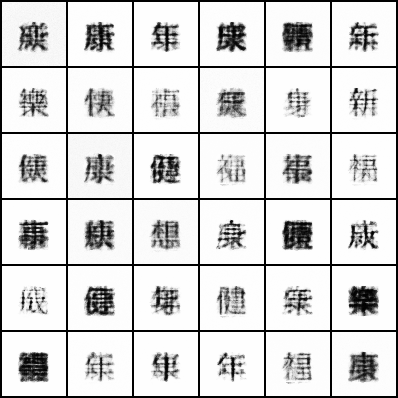

 68%|██████▊   | 17/25 [14:11<06:42, 50.32s/it]

Epoch[18/25], Total Loss: 1035.7817, Reconst Loss: 874.9460, KL Div: 160.8356555, Val Loss: 1314.1475


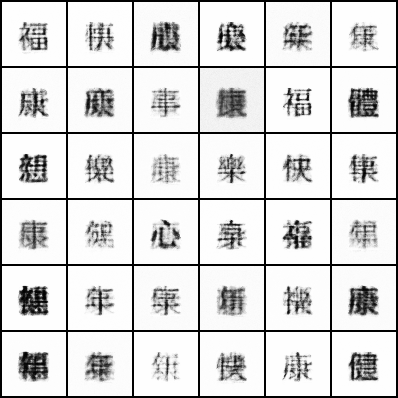

 72%|███████▏  | 18/25 [14:57<05:43, 49.03s/it]

Epoch[19/25], Total Loss: 1023.9231, Reconst Loss: 861.6446, KL Div: 162.2784865, Val Loss: 1252.9548


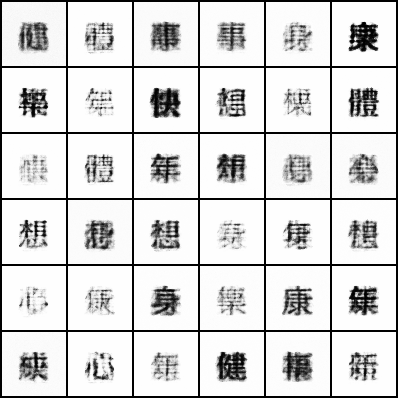

 76%|███████▌  | 19/25 [15:43<04:48, 48.04s/it]

Epoch[20/25], Total Loss: 1007.1694, Reconst Loss: 846.4474, KL Div: 160.7219813, Val Loss: 1258.8740


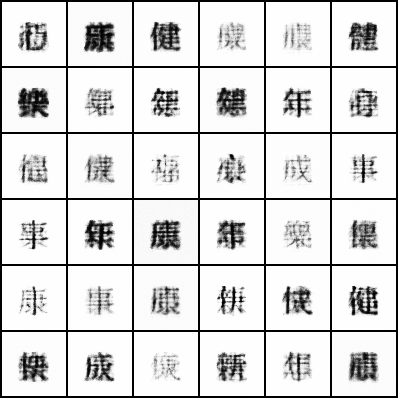

 80%|████████  | 20/25 [16:28<03:55, 47.13s/it]

Epoch[21/25], Total Loss: 995.2787, Reconst Loss: 832.4239, KL Div: 162.8547491, Val Loss: 1213.8478


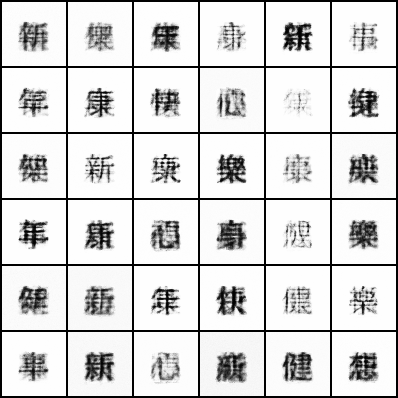

 84%|████████▍ | 21/25 [17:13<03:06, 46.62s/it]

Epoch[22/25], Total Loss: 989.3751, Reconst Loss: 824.0538, KL Div: 165.3212205, Val Loss: 1177.2990


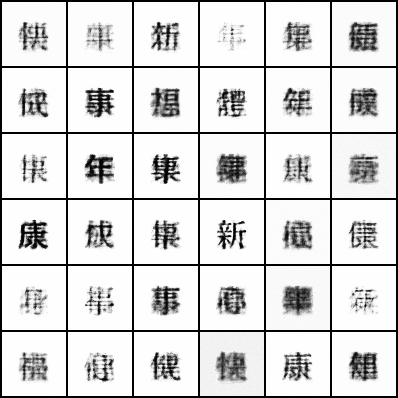

 88%|████████▊ | 22/25 [17:58<02:17, 45.93s/it]

Epoch[23/25], Total Loss: 983.0777, Reconst Loss: 817.6579, KL Div: 165.4197993, Val Loss: 1310.8935


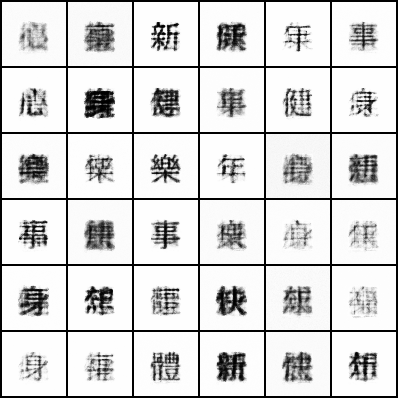

 92%|█████████▏| 23/25 [18:42<01:31, 45.53s/it]

Epoch[24/25], Total Loss: 975.3514, Reconst Loss: 807.1916, KL Div: 168.1598005, Val Loss: 1251.7271


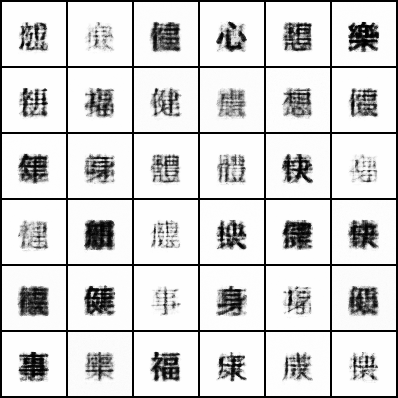

 96%|█████████▌| 24/25 [19:26<00:45, 45.06s/it]

Epoch[25/25], Total Loss: 958.4349, Reconst Loss: 792.2042, KL Div: 166.2306424, Val Loss: 1213.8323


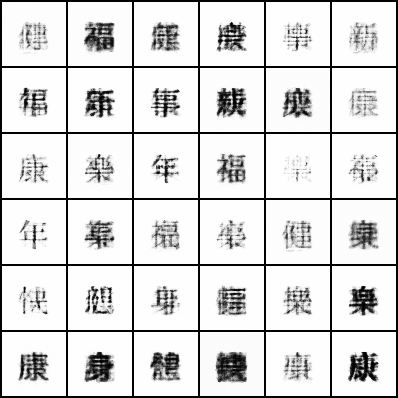

100%|██████████| 25/25 [20:11<00:00, 48.47s/it]


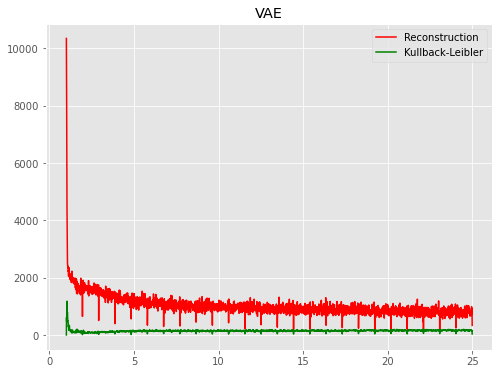

Sampled images from latent space:


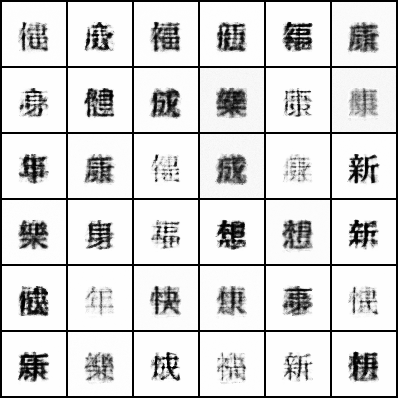

Interpolating between two randomly sampled


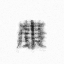

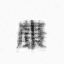

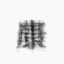

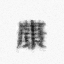

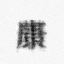

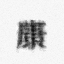

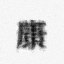

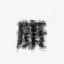

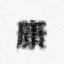

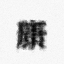

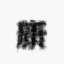

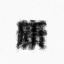

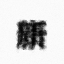

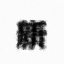

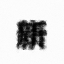

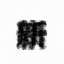

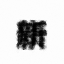

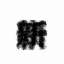

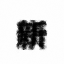

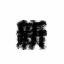

Exploring latent representations
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


  0%|          | 0/3 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x4096 and 784x400)

In [31]:
# import os, sys
# sys.path.append(os.path.abspath(os.path.join('../src/')))
    
# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binzarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

# Init model
model = VAE(image_size=image_size**2,
            hidden_dim=400,
            z_dim=20)

# Init trainer
trainer = VAETrainer(model=model,
                     train_iter=train_iter,
                     val_iter=val_iter,
                     test_iter=test_iter,
                     viz=True)

# Train
trainer.train(num_epochs=25,
              lr=1e-3,
              weight_decay=1e-5)

# Plot loss
trainer.viz_loss()

# Explore latent space
trainer.make_all()